In [123]:
'''
Seth Tyler
ISD503 Project
Fall 2021
'''

'\nSeth Tyler\nISD503 Project\nFall 2021\n'

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
from scipy.special import gamma, btdtri
import scipy.stats as ss

In [125]:
plt.rcParams['figure.figsize'] = (10,8)
michigan_blue = '#00274C'
powder_blue = '#E7F3F6'
verbose=0

In [126]:
def fix_axis(x=0, posterior_y=0):
    plt.ylabel(r'$\it{p(}$$\theta$)')
    plt.xlabel(r'$\theta$')

In [127]:
def find_stats(df, target=20):
    rslt_df = pd.DataFrame()
    rslt_df = df.copy()
    rslt_df['pandas_running_successes'] = rslt_df['Success_Bool'].cumsum()
    rslt_df['pandas_running_failures'] = rslt_df['Failure_Bool'].cumsum()
    rslt_df['pandas_running_launches'] = rslt_df['pandas_running_failures']+rslt_df['pandas_running_successes']
    successes = rslt_df['pandas_running_successes'].loc[rslt_df['pandas_running_launches'] == target].item()
    failures = rslt_df['pandas_running_failures'].loc[rslt_df['pandas_running_launches'] == target].item()

    return successes, failures

In [128]:
def calc_prior(prior_successes, prior_failures, new_successes, new_failures):
	'''
	Returns the PDF and relevant stats given passed values of past and new failures
	'''
	loc = 0
	scale = 1
	x = np.linspace(0,1,1000)
	lower_bound_limit = 0.05 #decimal
	upper_bound_limit = 0.95 #decimal

	prior_alpha = prior_failures
	prior_beta = prior_successes

	posterior_alpha = prior_failures + new_failures
	posterior_beta = prior_successes + new_successes

	if verbose:
		print('Prior alpha / beta:', prior_alpha, '/', prior_beta)
		print('Posterior alpha / beta:', posterior_alpha, '/', posterior_beta)

	prior_y = ss.beta.pdf(x, prior_alpha, prior_beta, loc, scale)
	posterior_y = ss.beta.pdf(x,posterior_alpha, posterior_beta,loc,scale)

	max_prior_y = np.argmax(prior_y)
	max_posterior_y = np.argmax(posterior_y)
	bayes_map_prior_x = x[max_prior_y]
	bayes_map_posterior_x = x[max_posterior_y]


	# prior_mean, prior_var, prior_skew, prior_kurt = ss.beta.stats(prior_alpha,prior_beta, moments = 'mvsk')
	# posterior_mean, posterior_var, posterior_skew, posterior_kurt = ss.beta.stats(posterior_alpha,posterior_beta, moments = 'mvsk')
	
	try:
		prior_MLE = (prior_alpha) / (prior_alpha + prior_beta)
	except:
		prior_MLE = 0
	
	try:
		posterior_MLE = (posterior_alpha) / (posterior_alpha + posterior_beta)
	except:
		posterior_MLE = 0

	if verbose:
		print('Prior / Posterior MLE is ', round(prior_MLE,3), '/', round(posterior_MLE, 3))


	prior_lower_cred_int = btdtri(prior_alpha, prior_beta, lower_bound_limit)
	prior_upper_cred_int = btdtri(prior_alpha, prior_beta, upper_bound_limit)
	posterior_lower_cred_int = btdtri(posterior_alpha, posterior_beta, lower_bound_limit)
	posterior_upper_cred_int = btdtri(posterior_alpha, posterior_beta, upper_bound_limit)


	# return x, prior_y, posterior_y, prior_mean, prior_var, prior_skew, prior_kurt, posterior_mean, posterior_var, posterior_skew, posterior_kurt, prior_MLE, posterior_MLE, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int
	return x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int

In [129]:
def plot_betas(x, prior_y, posterior_y, posterior_MLE, bayes_map_posterior_x, posterior_lower_cred_int, posterior_upper_cred_int, title):
	'''
	Plots the prior beta distribution and posterior beta distribution, along with the MLE and maximum bayesian estimate
	'''
# 	prior_label = r'prior: $\alpha_{prior}$ = ' + str(prior_failures) + r', $\beta_{prior}$ = ' + str(prior_successes)
# 	posterior_label = r'posterior: $\alpha_{posterior}$ = ' + str(prior_failures + new_failures) + r', $\beta_{posterior}$ = ' + str(prior_successes + new_successes)
	posterior_MLE_info='posterior MLE = '+str(round(posterior_MLE,3))
	bayes_map_posterior_x_info='Bayes MAP Estimate = '+str(round(bayes_map_posterior_x,3))
	plt.plot(x, prior_y, color='lightblue', linestyle='--')
	plt.plot(x, posterior_y, color='darkblue')
	plt.axvline(posterior_MLE, color='red',linestyle='--', label=posterior_MLE_info)
	plt.axvline(bayes_map_posterior_x, color='orange',linestyle='--', label=bayes_map_posterior_x_info)

	# plt.axvline(posterior_lower_cred_int, color='coral',linestyle='--', label='0.05')
	# plt.axvline(posterior_upper_cred_int, color='coral',linestyle='--', label='0.95')
	legend = plt.legend(loc='best', shadow=True, fontsize='large')
	if len(title) > 3:
		title_string = str(title)
	else:
		title_string = 'Bayesian Updating\nNew Successes / Failures: ' + str(new_successes) + ' / ' + str(new_failures)
	plt.fill_between(x,posterior_y,0,where=(x>posterior_lower_cred_int) & (x<=posterior_upper_cred_int), color='mistyrose')
	plt.title(title_string)
	plt.grid()
	fix_axis()
	plt.show()

In [130]:
datafile = '../08-Datasets/Aggregated_SLR_Dataset_v4.xlsx'
datatab = 'All'

# Import data for evaluation
df = pd.read_excel(datafile, sheet_name=datatab,engine="openpyxl")
df = df.reset_index()


In [131]:
def cutset_evaluation_spec_veh(targets=20, write_csv=False, plot_it=False):
    verbose = 0
    for target in targets:
        rslt_df = pd.DataFrame()
        plot_df = pd.DataFrame()

        vhcl_fam_list = []
        successes_at_target = []
        failures_at_target = []
        launches_at_target = []
        candidate_vhcl_fam_list = []


        Veh_Family=df['Veh_Family'].unique()
        Veh_Family.sort()

        for vhcl_fam in Veh_Family:
            if verbose: print('vhcl=',vhcl_fam)
            rslt_df = df.loc[df['Veh_Family']==vhcl_fam]

            rslt_df.set_index('Date')

            total_successes = max(rslt_df['Success_Bool'].cumsum())
            total_failures = max(rslt_df['Failure_Bool'].cumsum())
            total_launches = total_successes + total_failures

            if total_launches < target:
                if verbose: print(vhcl_fam,'has too few launches')
            else:
                candidate_vhcl_fam_list.append(vhcl_fam)
        
        
        if verbose: print('Candidate List at target of',target,':\n',candidate_vhcl_fam_list)

        interim_df = pd.DataFrame()
        rslt_df = pd.DataFrame()
        rslt_df = pd.DataFrame(columns=['vhcl_fam','launches_at_target','successes_at_target','failures_at_target'])

        for vhcl_fam in candidate_vhcl_fam_list:
            if verbose: print('vhcl=',vhcl_fam)
            interim_df = pd.DataFrame()
            interim_df = df.loc[df['Veh_Family']==vhcl_fam].copy()
            vhcl_fam_list.append(vhcl_fam)
            interim_df.set_index('Date')
            interim_df['pandas_running_successes'] = interim_df['Success_Bool'].cumsum()
            interim_df['pandas_running_failures'] = interim_df['Failure_Bool'].cumsum()
            interim_df['total_launches']=interim_df['pandas_running_successes'] + interim_df['pandas_running_failures']
            successes_at_target_interim = (interim_df['pandas_running_successes'].loc[interim_df['total_launches']==target].item())
            failures_at_target_interim = (interim_df['pandas_running_failures'].loc[interim_df['total_launches']==target].item())
            launches_at_target_interim = successes_at_target_interim+failures_at_target_interim

            if plot_it:
                prior_successes = 0
                prior_failures = 0
                new_successes = successes_at_target_interim
                new_failures = failures_at_target_interim
                x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
                plt.plot(x, posterior_y, color='darkblue', alpha=0.5)
                plt.axvline(bayes_map_posterior_x, color='orange', alpha=0.25, linestyle='--')

        if plot_it:
            plt.grid()
            fix_axis(x, posterior_y)
            #plt.xlim([0,0.125])
            plot_title='Plotting Specific Vehicles performance at ' + str(target) + ' launches'
            plt.title(plot_title)
            plt.show()
            plt.show()

            rslt_df = rslt_df.append({'vhcl_fam':vhcl_fam,'launches_at_target':launches_at_target_interim,'successes_at_target':successes_at_target_interim,'failures_at_target':failures_at_target_interim}, ignore_index=True)

        if write_csv == False:
            print('Not writing anything')


        if write_csv:
            filename='cutset_eval_spec_veh_'+str(target)+'.csv'
            print('Writing to:',filename)
            rslt_df.to_csv(filename, index=False)
    

In [132]:
cutset_evaluation_spec_veh(targets=[5,20,100], write_csv=False, plot_it=False)


Not writing anything
Not writing anything
Not writing anything


In [133]:
def cutset_evaluation_gen_veh(targets=20, write_csv=False, plot_it=False):
    verbose = 0
    for target in targets:
        rslt_df = pd.DataFrame()
        plot_df = pd.DataFrame()

        vhcl_fam_list = []
        successes_at_target = []
        failures_at_target = []
        launches_at_target = []
        candidate_vhcl_fam_list = []

        Veh_Family=df['Gen_Veh_Family'].unique()
        Veh_Family.sort()
        for vhcl_fam in Veh_Family:
            if verbose: print('vhcl=',vhcl_fam)
            rslt_df = df.loc[df['Gen_Veh_Family']==vhcl_fam]

            rslt_df.set_index('Date')

            total_successes = max(rslt_df['Success_Bool'].cumsum())
            total_failures = max(rslt_df['Failure_Bool'].cumsum())
            total_launches = total_successes + total_failures

            if total_launches < target:
                if verbose: print(vhcl_fam,'has too few launches')
            else:
                candidate_vhcl_fam_list.append(vhcl_fam)
        if verbose: print('Candidate List at target of',target,':\n',candidate_vhcl_fam_list)

        interim_df = pd.DataFrame()
        rslt_df = pd.DataFrame()
        rslt_df = pd.DataFrame(columns=['vhcl_fam','launches_at_target','successes_at_target','failures_at_target'])

        for vhcl_fam in candidate_vhcl_fam_list:
            if verbose: print('vhcl=',vhcl_fam)
            interim_df = df.loc[df['Gen_Veh_Family']==vhcl_fam].copy()
            vhcl_fam_list.append(vhcl_fam)
            interim_df.set_index('Date')
            interim_df['pandas_running_successes'] = interim_df['Success_Bool'].cumsum()
            interim_df['pandas_running_failures'] = interim_df['Failure_Bool'].cumsum()
            interim_df['total_launches']=interim_df['pandas_running_successes'] + interim_df['pandas_running_failures']
            successes_at_target_interim = (interim_df['pandas_running_successes'].loc[interim_df['total_launches']==target].item())
            failures_at_target_interim = (interim_df['pandas_running_failures'].loc[interim_df['total_launches']==target].item())
            launches_at_target_interim = successes_at_target_interim+failures_at_target_interim

            if plot_it:
                prior_successes = 0
                prior_failures = 0
                new_successes = successes_at_target_interim
                new_failures = failures_at_target_interim
                x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
                plt.plot(x, posterior_y, color='darkblue', alpha=0.5)
                plt.axvline(bayes_map_posterior_x, color='orange', alpha=0.25, linestyle='--')

        if plot_it:
            plt.grid()
            fix_axis(x, posterior_y)
            #plt.xlim([0,0.125])
            plot_title='Plotting General Vehicles performance at ' + str(target) + ' launches'
            plt.title(plot_title)
            plt.show()

            rslt_df = rslt_df.append({'vhcl_fam':vhcl_fam,'launches_at_target':launches_at_target_interim,'successes_at_target':successes_at_target_interim,'failures_at_target':failures_at_target_interim}, ignore_index=True)

        if write_csv == False:
            print('Not writing anything')

        if write_csv:
            filename='cutset_eval_gen_veh_'+str(target)+'.csv'
            print('Writing to:',filename)
            rslt_df.to_csv(filename, index=False)
    

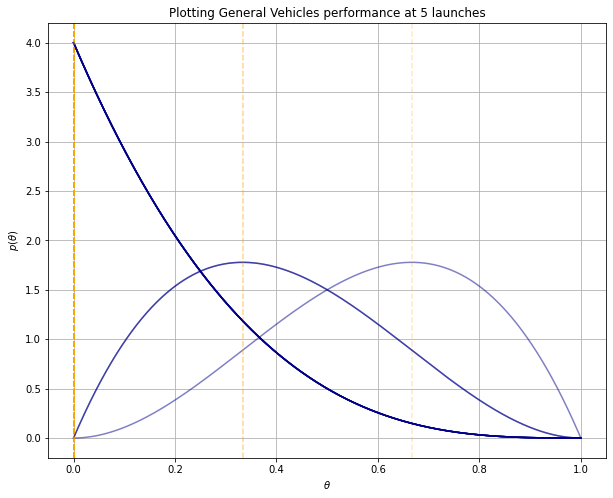

Not writing anything


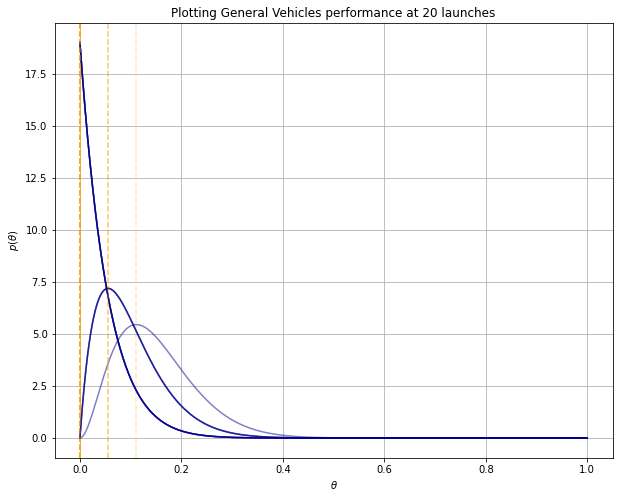

Not writing anything


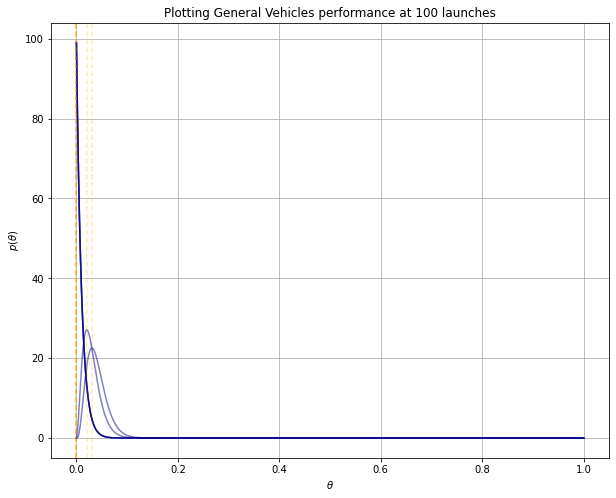

Not writing anything


In [134]:
cutset_evaluation_gen_veh(targets=[5,20,100],write_csv=False, plot_it=True)


In [156]:
def cutset_evaluation_stage_all_launches(stages=3, write_csv=False, plot_it=False):
    verbose = 0
    launches = []
    upper_text_loc = []
    for stage in stages:    
        print("running stage:",stage)

        interim_df = df.loc[df['Number_of_Stages']==stage].copy()
        
        interim_df['pandas_running_successes'] = interim_df['Success_Bool'].cumsum()
        interim_df['pandas_running_failures'] = interim_df['Failure_Bool'].cumsum()
        successes_stage_max = max(interim_df['pandas_running_successes'])
        failures_stage_max = max(interim_df['pandas_running_failures'])
        launches_stage_max = successes_stage_max+failures_stage_max
        launches.append(launches_stage_max)

        if plot_it:
            # errorbar approach
            prior_successes = 0
            prior_failures = 0
            new_successes = successes_stage_max
            new_failures = failures_stage_max
            x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
            stage_label='Stage label = ' + str(stage)
            #print(stage, bayes_map_posterior_x, posterior_lower_cred_int,posterior_upper_cred_int)
            asymmetric_error = np.array(bayes_map_posterior_x-posterior_lower_cred_int, posterior_upper_cred_int-bayes_map_posterior_x)
            upper_text_loc.append(bayes_map_posterior_x)
            plt.errorbar(stage, bayes_map_posterior_x, yerr=asymmetric_error, fmt='>', capsize=10, color=michigan_blue, elinewidth=3, capthick=2, markersize=12)
#             plt.axvline(bayes_map_posterior_x, color='orange', alpha=0.25, linestyle='--')           
            
        if write_csv == False:
            print('Not writing anything')

        if write_csv:
            filename='cutset_eval_stage_'+str(stage)+'.csv'
            print('Writing to:',filename)
            rslt_df.to_csv(filename, index=False)
            
    if plot_it:

        plt.grid()
        plt.xlabel('Stages')
        plt.ylabel(r'p($\theta$)')
        plt.title('MAP and Credible Interval vs # of Stages - Total Dataset')
        x_ticks=np.arange(1,max(stages)+2,1)
        plt.xticks(x_ticks)
        plt.ylim(0,0.1)      
        text_box = []
        for i in range(0,len(stages)):
            text_content='Launches:\n'+str(launches[i])
            plt.text(stages[i],.015,text_content,bbox=dict(facecolor='lightgray',boxstyle='round,pad=0.25',alpha=0.95), ha="center", va="center")
        
        plt.text(1.75,0.08,"Stages 2.5, 3.5, and 5\nhave insufficient launches",bbox=dict(facecolor='lightgray',boxstyle='round,pad=0.25',alpha=0.95), ha="center", va="center")
        
        plt.savefig('MAP_and_CI_vs_Stage_Count_Total_Data.png', dpi = 300, bbox_inches='tight')

        plt.show()
           
    

[1 2 3]
running stage: 2
Not writing anything
running stage: 3
Not writing anything
running stage: 4
Not writing anything


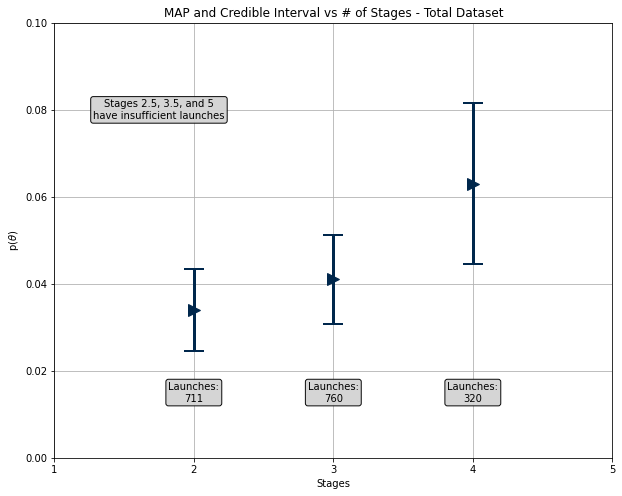

In [158]:
stages=df['Number_of_Stages_Category'].unique()
stages.sort()
print(stages)

stages=[2,3,4] #because 2.5, 3.5, and 5 don't work for some reason

cutset_evaluation_stage_all_launches(stages=stages, write_csv=False, plot_it=True)


running category: 1
Not writing anything
running category: 2
Not writing anything


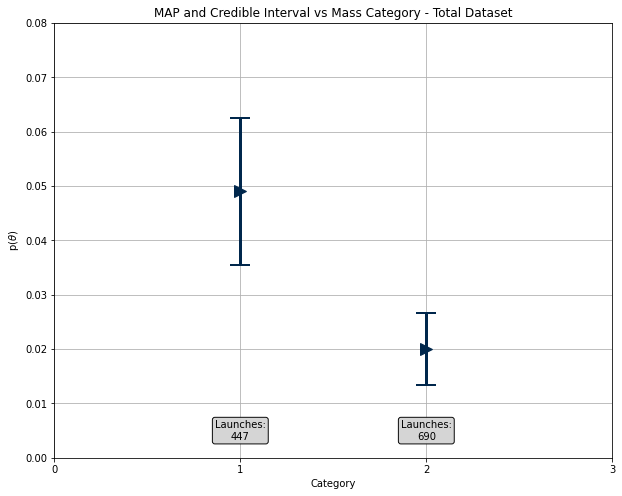

need to make this for the first 5, 20 launches.  As is, it looks like frequentist due to so many launches


In [137]:
#This plots the MAP and Credible Interval for the Full DataSet based upon Mass Category

def cutset_evaluation_mass_all_launches(categories=3, write_csv=False, plot_it=False):
    verbose = 0
    launches = []
    upper_text_loc = []
    for category in categories:    
        print("running category:",category)

        interim_df = df.loc[df['Mass_Cat']==category].copy()
        
        interim_df['pandas_running_successes'] = interim_df['Success_Bool'].cumsum()
        interim_df['pandas_running_failures'] = interim_df['Failure_Bool'].cumsum()
        successes_category_max = max(interim_df['pandas_running_successes'])
        failures_category_max = max(interim_df['pandas_running_failures'])
        launches_category_max = successes_category_max+failures_category_max
        launches.append(launches_category_max)

        if plot_it:
            # errorbar approach
            prior_successes = 0
            prior_failures = 0
            new_successes = successes_category_max
            new_failures = failures_category_max
            x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
            category_label='category label = ' + str(category)
            #print(stage, bayes_map_posterior_x, posterior_lower_cred_int,posterior_upper_cred_int)
            asymmetric_error = np.array(bayes_map_posterior_x-posterior_lower_cred_int, posterior_upper_cred_int-bayes_map_posterior_x)
            upper_text_loc.append(bayes_map_posterior_x)
            plt.errorbar(category, bayes_map_posterior_x, yerr=asymmetric_error, fmt='>', capsize=10, color=michigan_blue, elinewidth=3, capthick=2, markersize=12)
#             plt.axvline(bayes_map_posterior_x, color='orange', alpha=0.25, linestyle='--')           
            
        if write_csv == False:
            print('Not writing anything')

        if write_csv:
            filename='cutset_eval_mass_'+str(category)+'.csv'
            print('Writing to:',filename)
            rslt_df.to_csv(filename, index=False)
            
    if plot_it:

        plt.grid()
        plt.xlabel('Category')
        plt.ylabel(r'p($\theta$)')
        plt.title('MAP and Credible Interval vs Mass Category - Total Dataset')
        x_ticks=np.arange(0,max(categories)+2,1)
        plt.xticks(x_ticks)
        plt.ylim(0,0.08)      
        text_box = []
        for i in range(0,len(categories)):
            text_content='Launches:\n'+str(launches[i])
            plt.text(categories[i],.005,text_content,bbox=dict(facecolor='lightgray',boxstyle='round,pad=0.25',alpha=0.95), ha="center", va="center")
        plt.savefig('MAP_and_CI_vs_Mass_Cat_Total_Data.png', dpi = 300, bbox_inches='tight')

        plt.show()

        
datafile = '../08-Datasets/Aggregated_SLR_Dataset_v4.xlsx'
datatab = 'All'

# Import data for evaluation
df = pd.read_excel(datafile, sheet_name=datatab,engine="openpyxl")
df = df.reset_index()

categories=[1,2] #Ranges for mass: 1:0-2.5, 2:2.5-25, 3:>25, set in the Excel file

cutset_evaluation_mass_all_launches(categories=categories, write_csv=False, plot_it=True)

print('need to make this for the first 5, 20 launches.  As is, it looks like frequentist due to so many launches')

running generation: 1
Not writing anything
running generation: 2
Not writing anything
running generation: 3
Not writing anything


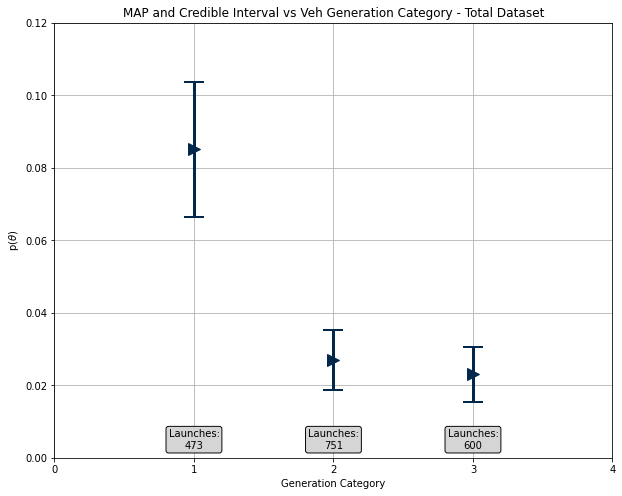

In [138]:
#This plots the MAP and Credible Interval for the Full DataSet based upon Veh Generation

def cutset_evaluation_gen_all_launches(generations=3, write_csv=False, plot_it=False):
    verbose = 0
    launches = []
    upper_text_loc = []
    for generation in generations:    
        print("running generation:",generation)

        interim_df = df.loc[df['Veh_Generation_Category']==generation].copy()
        
        interim_df['pandas_running_successes'] = interim_df['Success_Bool'].cumsum()
        interim_df['pandas_running_failures'] = interim_df['Failure_Bool'].cumsum()
        successes_generation_max = max(interim_df['pandas_running_successes'])
        failures_generation_max = max(interim_df['pandas_running_failures'])
        launches_generation_max = successes_generation_max+failures_generation_max
        launches.append(launches_generation_max)

        if plot_it:
            # errorbar approach
            prior_successes = 0
            prior_failures = 0
            new_successes = successes_generation_max
            new_failures = failures_generation_max
            x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
            category_label='generation label = ' + str(generation)
            #print(stage, bayes_map_posterior_x, posterior_lower_cred_int,posterior_upper_cred_int)
            asymmetric_error = np.array(bayes_map_posterior_x-posterior_lower_cred_int, posterior_upper_cred_int-bayes_map_posterior_x)
            upper_text_loc.append(bayes_map_posterior_x)
            plt.errorbar(generation, bayes_map_posterior_x, yerr=asymmetric_error, fmt='>', capsize=10, color=michigan_blue, elinewidth=3, capthick=2, markersize=12)
#             plt.axvline(bayes_map_posterior_x, color='orange', alpha=0.25, linestyle='--')           
            
        if write_csv == False:
            print('Not writing anything')

        if write_csv:
            filename='cutset_eval_gen_'+str(generation)+'.csv'
            print('Writing to:',filename)
            rslt_df.to_csv(filename, index=False)
            
    if plot_it:

        plt.grid()
        plt.xlabel('Generation Category')
        plt.ylabel(r'p($\theta$)')
        plt.title('MAP and Credible Interval vs Veh Generation Category - Total Dataset')
        x_ticks=np.arange(0,max(generations)+2,1)
        plt.xticks(x_ticks)
        plt.ylim(0,0.12)      
        text_box = []
        for i in range(0,len(generations)):
            text_content='Launches:\n'+str(launches[i])
            plt.text(generations[i],.005,text_content,bbox=dict(facecolor='lightgray',boxstyle='round,pad=0.25',alpha=0.95), ha="center", va="center")
        plt.savefig('MAP_and_CI_vs_Veh_Gen_Total_Data.png', dpi = 300, bbox_inches='tight')

        plt.show()

        
datafile = '../08-Datasets/Aggregated_SLR_Dataset_v4.xlsx'
datatab = 'All'

# Import data for evaluation
df = pd.read_excel(datafile, sheet_name=datatab,engine="openpyxl")
df = df.reset_index()

generations=[1,2,3] #Ranges for mass: 1:0-2.5, 2:2.5-25, 3:>25, set in the Excel file

cutset_evaluation_gen_all_launches(generations=generations, write_csv=False, plot_it=True)



running category: 1
Not writing anything
running category: 2
Not writing anything


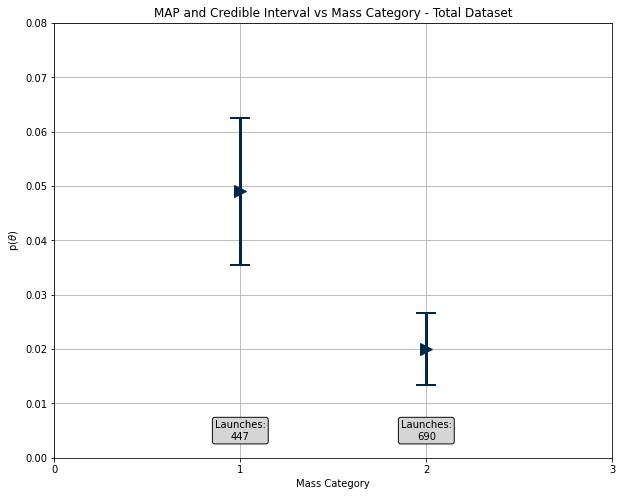

In [151]:
#This plots the MAP and Credible Interval for the first "X" launches of each vehicle based upon Mass Category

def cutset_evaluation_mass_all_launches(categories=3, target = 20, write_csv=False, plot_it=False):
    verbose = 0
    launches = []
    upper_text_loc = []
    for category in categories:    
        print("running category:",category)

        interim_df = df.loc[df['Mass_Cat']==category].copy()
        
        interim_df['pandas_running_successes'] = interim_df['Success_Bool'].cumsum()
        interim_df['pandas_running_failures'] = interim_df['Failure_Bool'].cumsum()
        successes_category_max = max(interim_df['pandas_running_successes'])
        failures_category_max = max(interim_df['pandas_running_failures'])
        launches_category_max = successes_category_max+failures_category_max
        launches.append(launches_category_max)

        if plot_it:
            # errorbar approach
            prior_successes = 0
            prior_failures = 0
            new_successes = successes_category_max
            new_failures = failures_category_max
            x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
            category_label='category label = ' + str(category)
            #print(stage, bayes_map_posterior_x, posterior_lower_cred_int,posterior_upper_cred_int)
            asymmetric_error = np.array(bayes_map_posterior_x-posterior_lower_cred_int, posterior_upper_cred_int-bayes_map_posterior_x)
            upper_text_loc.append(bayes_map_posterior_x)
            plt.errorbar(category, bayes_map_posterior_x, yerr=asymmetric_error, fmt='>', capsize=10, color=michigan_blue, elinewidth=3, capthick=2, markersize=12)
#             plt.axvline(bayes_map_posterior_x, color='orange', alpha=0.25, linestyle='--')           
            
        if write_csv == False:
            print('Not writing anything')

        if write_csv:
            filename='cutset_eval_mass_'+str(category)+'.csv'
            print('Writing to:',filename)
            rslt_df.to_csv(filename, index=False)
            
    if plot_it:

        plt.grid()
        plt.xlabel('Mass Category')
        plt.ylabel(r'p($\theta$)')
        plt.title('MAP and Credible Interval vs Mass Category - Total Dataset')
        x_ticks=np.arange(0,max(categories)+2,1)
        plt.xticks(x_ticks)
        plt.ylim(0,0.08)      
        text_box = []
        for i in range(0,len(categories)):
            text_content='Launches:\n'+str(launches[i])
            plt.text(categories[i],.005,text_content,bbox=dict(facecolor='lightgray',boxstyle='round,pad=0.25',alpha=0.95), ha="center", va="center")


        plt.show()

        
datafile = '../08-Datasets/Aggregated_SLR_Dataset_v4.xlsx'
datatab = 'All'

# Import data for evaluation
df = pd.read_excel(datafile, sheet_name=datatab,engine="openpyxl")
df = df.reset_index()

categories=[1,2] #Ranges for mass: 1:0-2.5, 2:2.5-25, 3:>25, set in the Excel file
target = [5,20,100]
cutset_evaluation_mass_all_launches(categories=categories, target=target, write_csv=False, plot_it=True)

In [140]:
datafile = '../08-Datasets/Aggregated_SLR_Dataset_v4.xlsx'
datatab = 'All'

# Import data for evaluation
df = pd.read_excel(datafile, sheet_name=datatab,engine="openpyxl")
df = df.reset_index()


In [141]:
# This is used to create the figure for the following: Posterior Density Function for Failure Fraction (1-5 launches)
def exclusion_analysis_all_vehicles(targets=20, linestyle='-',write_csv=False, plot_it=False):
    verbose = 0
    
    for target in targets:
        num_failures = 0
        num_successes = 0
        num_launches = 0
        
        rslt_df = pd.DataFrame()
        plot_df = pd.DataFrame()

        vhcl_fam_list = []
        successes_at_target = []
        failures_at_target = []
        launches_at_target = []
        candidate_vhcl_fam_list = []

        Veh_Family=df['Veh_Family'].unique()
        Veh_Family.sort()

        for vhcl_fam in Veh_Family:
            if verbose: print('vhcl=',vhcl_fam)
            rslt_df = df.loc[df['Veh_Family']==vhcl_fam]

            rslt_df.set_index('Date')

            total_successes = max(rslt_df['Success_Bool'].cumsum())
            total_failures = max(rslt_df['Failure_Bool'].cumsum())
            total_launches = total_successes + total_failures

            if total_launches < target:
                if verbose: print(vhcl_fam,'has too few launches')
            else:
                candidate_vhcl_fam_list.append(vhcl_fam)
            
        
        if verbose: print('Candidate List at target of',target,':\n',candidate_vhcl_fam_list)

        interim_df = pd.DataFrame()
        rslt_df = pd.DataFrame()
        rslt_df = pd.DataFrame(columns=['vhcl_fam','launches_at_target','successes_at_target','failures_at_target'])

        for vhcl_fam in candidate_vhcl_fam_list:
            if verbose: print('vhcl=',vhcl_fam)
            interim_df = pd.DataFrame()
            interim_df = df.loc[df['Veh_Family']==vhcl_fam].copy()
            vhcl_fam_list.append(vhcl_fam)
            interim_df.set_index('Date')
            
            
            if verbose: print(vhcl_fam, target, interim_df['Failure_Bool'].iloc[target-1])
            num_failures += interim_df['Failure_Bool'].iloc[target-1]
            num_successes += interim_df['Success_Bool'].iloc[target-1]

            if verbose: print(num_failures, num_successes)
        
        print("Launch Target: ", target, "Failures: ", num_failures, "Successes: ", num_successes, "Total Launches: ", num_failures+num_successes)
        
        if plot_it:
            prior_successes = 0
            prior_failures = 0
            new_successes = num_successes
            new_failures = num_failures
            x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
            plot_label= 'Launch number '+ str(target) +' - F/S: ' + str(num_failures) + '/' + str(num_successes)
            if len(targets) == 1: plt.axvline(bayes_map_posterior_x, color='orange', alpha=0.25, linestyle='--')
            if len(linestyle) < 2: plt.plot(x, posterior_y, alpha=0.5,label=plot_label)
            if len(linestyle) >= 2: plt.plot(x, posterior_y, alpha=0.5,label=plot_label, linestyle=linestyle[target-1])

#         if plot_it:
#             plt.grid()
#             fix_axis(x, posterior_y)
#             #plt.xlim([0,0.125])
#             plot_title='Plotting Specific Vehicles performance at ' + str(target) + ' launches'
#             plt.title(plot_title)
#             plt.show()
#             plt.show()


#         if write_csv == False:
#             print('Not writing anything')


#         if write_csv:
#             filename='cutset_eval_spec_veh_'+str(target)+'.csv'
#             print('Writing to:',filename)
#             rslt_df.to_csv(filename, index=False)




Launch Target:  5 Failures:  14 Successes:  206 Total Launches:  220


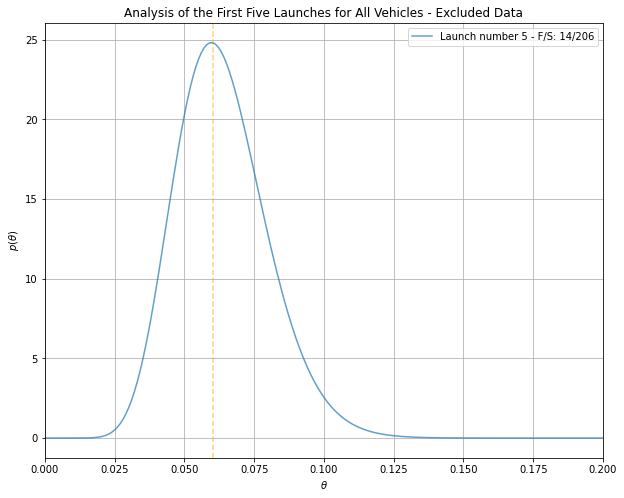

In [142]:
# This is used to create the figure for the following: Analysis of the First Five Launches for All Vehicles
def exclusion_analysis_all_vehicles_aggregate_launches(targets=20, linestyle='-',write_csv=False, plot_it=False):
    verbose = 0
    failures = 0
    successes = 0
    
    for target in targets:
        num_failures = 0
        num_successes = 0
        num_launches = 0
        
        rslt_df = pd.DataFrame()
        plot_df = pd.DataFrame()

        vhcl_fam_list = []
        successes_at_target = []
        failures_at_target = []
        launches_at_target = []
        candidate_vhcl_fam_list = []

        Veh_Family=df['Veh_Family'].unique()
        Veh_Family.sort()

        for vhcl_fam in Veh_Family:
            if verbose: print('vhcl=',vhcl_fam)
            rslt_df = df.loc[df['Veh_Family']==vhcl_fam]

            rslt_df.set_index('Date')

            total_successes = max(rslt_df['Success_Bool'].cumsum())
            total_failures = max(rslt_df['Failure_Bool'].cumsum())
            total_launches = total_successes + total_failures

            if total_launches < target:
                if verbose: print(vhcl_fam,'has too few launches')
            else:
                candidate_vhcl_fam_list.append(vhcl_fam)
            
        
        if verbose: print('Candidate List at target of',target,':\n',candidate_vhcl_fam_list)

        interim_df = pd.DataFrame()
        rslt_df = pd.DataFrame()
        rslt_df = pd.DataFrame(columns=['vhcl_fam','launches_at_target','successes_at_target','failures_at_target'])

        for vhcl_fam in candidate_vhcl_fam_list:
            if verbose: print('vhcl=',vhcl_fam)
            interim_df = pd.DataFrame()
            interim_df = df.loc[df['Veh_Family']==vhcl_fam].copy()
            vhcl_fam_list.append(vhcl_fam)
            interim_df.set_index('Date')
                        
            successes, failures = find_stats(interim_df, target=target)
            if verbose: print(vhcl_fam, successes, failures)
            
            num_failures += failures
            num_successes += successes

            if verbose: print(num_failures, num_successes)
        
        print("Launch Target: ", target, "Failures: ", num_failures, "Successes: ", num_successes, "Total Launches: ", num_failures+num_successes)
        
        if plot_it:
            prior_successes = 0
            prior_failures = 0
            new_successes = num_successes
            new_failures = num_failures
            x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
            plot_label= 'Launch number '+ str(target) +' - F/S: ' + str(num_failures) + '/' + str(num_successes)
            if len(targets) == 1: plt.axvline(bayes_map_posterior_x, color='orange', alpha=0.5, linestyle='--')
            if len(linestyle) < 2: plt.plot(x, posterior_y, alpha=0.7,label=plot_label)
            if len(linestyle) >= 2: plt.plot(x, posterior_y, alpha=0.7,label=plot_label, linestyle=linestyle[target-1])

#         if plot_it:
#             plt.grid()
#             fix_axis(x, posterior_y)
#             #plt.xlim([0,0.125])
#             plot_title='Plotting Specific Vehicles performance at ' + str(target) + ' launches'
#             plt.title(plot_title)
#             plt.show()
#             plt.show()


#         if write_csv == False:
#             print('Not writing anything')


#         if write_csv:
#             filename='cutset_eval_spec_veh_'+str(target)+'.csv'
#             print('Writing to:',filename)
#             rslt_df.to_csv(filename, index=False)

datafile = '../08-Datasets/Aggregated_SLR_Dataset_v4.xlsx'
datatab = 'All-exclusions'

# Import data for evaluation
df = pd.read_excel(datafile, sheet_name=datatab,engine="openpyxl")
df = df.reset_index()

targets=[5]
linestyle=['-','--',':','-.','-']
exclusion_analysis_all_vehicles_aggregate_launches(targets=targets, write_csv=False, plot_it=True)


plt.title('Analysis of the First Five Launches for All Vehicles - Excluded Data')
plt.grid()
plt.legend()
plt.xlim(0,0.20)
fix_axis()
plt.savefig('first_5_launches_excluded_data.png', dpi = 300, bbox_inches='tight')

plt.show()


running category: 1
Launch Target:  5 Failures:  6 Successes:  109 Total Launches:  115
running category: 2
Launch Target:  5 Failures:  2 Successes:  83 Total Launches:  85
running category: 3
Launch Target:  5 Failures:  0 Successes:  5 Total Launches:  5


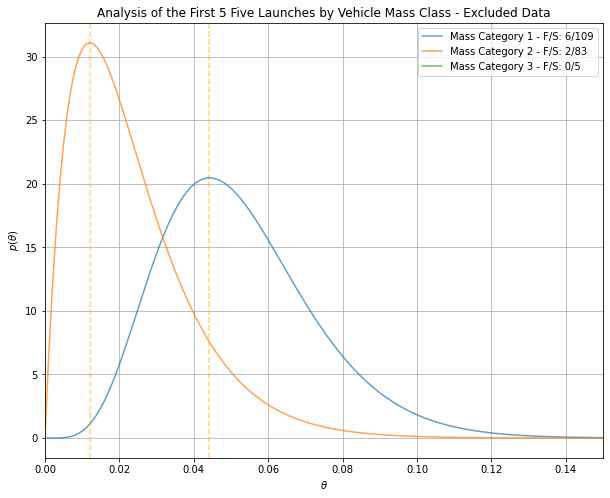

In [143]:
# This is used to create the figure for the following: Analysis of the First Five Launches for Vehicle Mass Class
def exclusion_analysis_all_vehicles_aggregate_launches_by_mass_cat(targets=20, categories=1,linestyle='-',write_csv=False, plot_it=False):
    verbose = 0
    failures = 0
    successes = 0
    
    for target in targets:
        num_failures = 0
        num_successes = 0
        num_launches = 0
        
        rslt_df = pd.DataFrame()
        plot_df = pd.DataFrame()

        vhcl_fam_list = []
        successes_at_target = []
        failures_at_target = []
        launches_at_target = []
        candidate_vhcl_fam_list = []

        for category in categories:    
            num_failures = 0
            num_successes = 0
            num_launches = 0
            
            print("running category:",category)

            interim_df = df.loc[df['Mass_Cat']==category].copy()
        
            Veh_Family=interim_df['Veh_Family'].unique()
            Veh_Family.sort()

            for vhcl_fam in Veh_Family:
                if verbose: print('vhcl=',vhcl_fam)
                rslt_df = interim_df.loc[df['Veh_Family']==vhcl_fam]

                interim_df.set_index('Date')

                try:
                    successes, failures = find_stats(rslt_df, target=target)
                except:
                    successes, failures = 0,0
                
                if verbose: print(vhcl_fam, successes, failures)

                num_failures += failures
                num_successes += successes

                if verbose: print(num_failures, num_successes)

            print("Launch Target: ", target, "Failures: ", num_failures, "Successes: ", num_successes, "Total Launches: ", num_failures+num_successes)

            if plot_it:
                prior_successes = 0
                prior_failures = 0
                new_successes = num_successes
                new_failures = num_failures
                x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
                plot_label= 'Mass Category '+ str(category) +' - F/S: ' + str(num_failures) + '/' + str(num_successes)
                if len(targets) == 1: plt.axvline(bayes_map_posterior_x, color='orange', alpha=0.5, linestyle='--')
                if len(linestyle) < 2: plt.plot(x, posterior_y, alpha=0.7,label=plot_label)
                if len(linestyle) >= 2: plt.plot(x, posterior_y, alpha=0.7,label=plot_label, linestyle=linestyle[target-1])

    #         if plot_it:
    #             plt.grid()
    #             fix_axis(x, posterior_y)
    #             #plt.xlim([0,0.125])
    #             plot_title='Plotting Specific Vehicles performance at ' + str(target) + ' launches'
    #             plt.title(plot_title)
    #             plt.show()
    #             plt.show()


    #         if write_csv == False:
    #             print('Not writing anything')


    #         if write_csv:
    #             filename='cutset_eval_spec_veh_'+str(target)+'.csv'
    #             print('Writing to:',filename)
    #             rslt_df.to_csv(filename, index=False)

datafile = '../08-Datasets/Aggregated_SLR_Dataset_v4.xlsx'
datatab = 'All-exclusions'

# Import data for evaluation
df = pd.read_excel(datafile, sheet_name=datatab,engine="openpyxl")
df = df.reset_index()

targets=[5]
categories=[1,2,3]
linestyle=['-','--',':','-.','-']
exclusion_analysis_all_vehicles_aggregate_launches_by_mass_cat(targets=targets, categories=categories,write_csv=False, plot_it=True)

title_string = 'Analysis of the First ' + str(targets[0]) +' Five Launches by Vehicle Mass Class - Excluded Data'

plt.title(title_string)
plt.grid()
plt.legend()
plt.xlim(0,0.15)
fix_axis()
plt.savefig('first_5_launches_mass_cat_excluded_data.png', dpi = 300, bbox_inches='tight')
plt.show()

Launch Target:  5 Stages: 2 Failures:  7 Successes:  73 Total Launches:  80
Launch Target:  5 Stages: 3 Failures:  6 Successes:  74 Total Launches:  80
Launch Target:  5 Stages: 3.5 Failures:  0 Successes:  5 Total Launches:  5
Launch Target:  5 Stages: 4 Failures:  1 Successes:  59 Total Launches:  60
Launch Target:  5 Stages: 5 Failures:  0 Successes:  0 Total Launches:  0


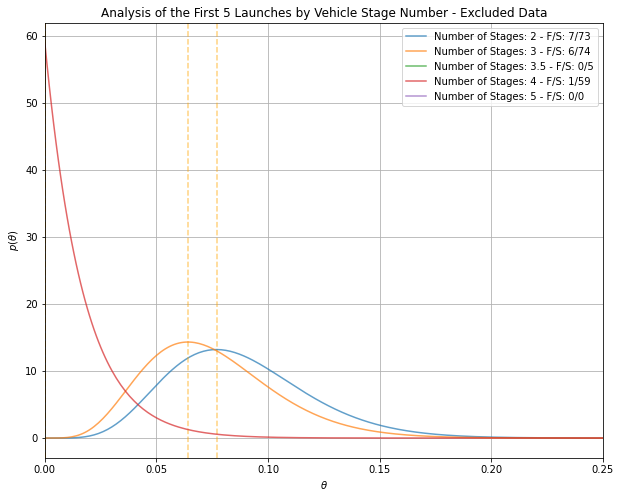

In [144]:
# This is used to create the figure for the following: Analysis of the First Five Launches for Vehicle Stages Class
def exclusion_analysis_all_vehicles_aggregate_launches_by_stages(targets=20, stages=1,linestyle='-',write_csv=False, plot_it=False):
    verbose = 0
    failures = 0
    successes = 0
    
    for target in targets:
        num_failures = 0
        num_successes = 0
        num_launches = 0
        
        rslt_df = pd.DataFrame()
        plot_df = pd.DataFrame()

        vhcl_fam_list = []
        successes_at_target = []
        failures_at_target = []
        launches_at_target = []
        candidate_vhcl_fam_list = []

        for stage in stages:    
            num_failures = 0
            num_successes = 0
            num_launches = 0
            
            if verbose: print("running stage:",stage)

            interim_df = df.loc[df['Number_of_Stages']==stage].copy()
        
            Veh_Family=interim_df['Veh_Family'].unique()
            Veh_Family.sort()

            for vhcl_fam in Veh_Family:
                if verbose: print('vhcl=',vhcl_fam)
                rslt_df = interim_df.loc[df['Veh_Family']==vhcl_fam]

                interim_df.set_index('Date')

                try:
                    successes, failures = find_stats(rslt_df, target=target)
                except:
                    successes, failures = 0,0
                
                if verbose: print(vhcl_fam, successes, failures)

                num_failures += failures
                num_successes += successes

                if verbose: print(num_failures, num_successes)

            print("Launch Target: ", target, "Stages:", stage, "Failures: ", num_failures, "Successes: ", num_successes, "Total Launches: ", num_failures+num_successes)

            if plot_it:
                prior_successes = 0
                prior_failures = 0
                new_successes = num_successes
                new_failures = num_failures
                x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
                plot_label= 'Number of Stages: '+ str(stage) +' - F/S: ' + str(num_failures) + '/' + str(num_successes)
                if len(targets) == 1: plt.axvline(bayes_map_posterior_x, color='orange', alpha=0.5, linestyle='--')
                if len(linestyle) < 2: plt.plot(x, posterior_y, alpha=0.7,label=plot_label)
                if len(linestyle) >= 2: plt.plot(x, posterior_y, alpha=0.7,label=plot_label, linestyle=linestyle[target-1])

    #         if plot_it:
    #             plt.grid()
    #             fix_axis(x, posterior_y)
    #             #plt.xlim([0,0.125])
    #             plot_title='Plotting Specific Vehicles performance at ' + str(target) + ' launches'
    #             plt.title(plot_title)
    #             plt.show()
    #             plt.show()


    #         if write_csv == False:
    #             print('Not writing anything')


    #         if write_csv:
    #             filename='cutset_eval_spec_veh_'+str(target)+'.csv'
    #             print('Writing to:',filename)
    #             rslt_df.to_csv(filename, index=False)

datafile = '../08-Datasets/Aggregated_SLR_Dataset_v4.xlsx'
datatab = 'All-exclusions'

# Import data for evaluation
df = pd.read_excel(datafile, sheet_name=datatab,engine="openpyxl")
df = df.reset_index()

targets=[5]
stages=[2,3, 3.5, 4, 5] 

linestyle=['-','--',':','-.','-']
exclusion_analysis_all_vehicles_aggregate_launches_by_stages(targets=targets, stages=stages,write_csv=False, plot_it=True)

title_string = 'Analysis of the First ' + str(targets[0]) + ' Launches by Vehicle Stage Number - Excluded Data'

plt.title(title_string)
plt.grid()
plt.legend()
plt.xlim(0,0.25)
fix_axis()
plt.savefig('first_5_launches_stage_excluded_data.png', dpi = 300, bbox_inches='tight')

plt.show()

masscat: 1 gen: 1 stages: 3
Total successes:  38 , Total failures:  3
launch: 0 MAP: 0.051 lower cred: 0.021 upper cred: 0.149
1 1 0 1
2 1 0 2
3 1 0 3
4 0 1 3
5 0 2 3
6 0 3 3
7 0 4 3
you need to put something here!


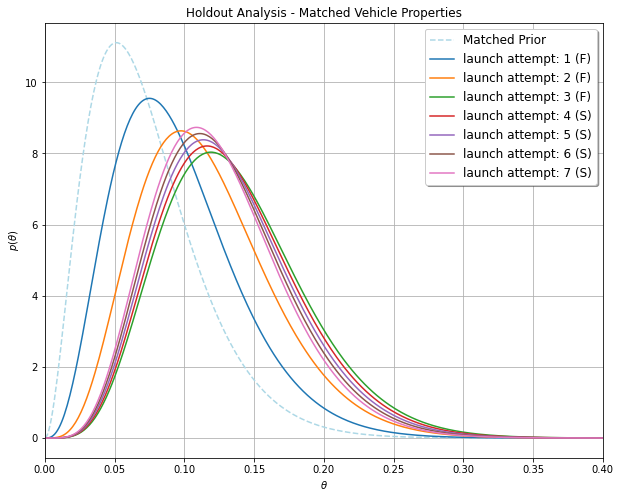

launch: 1 MAP: 0.074 lower cred: 0.041 upper cred: 0.139
launch: 2 MAP: 0.085 lower cred: 0.049 upper cred: 0.153
launch: 3 MAP: 0.096 lower cred: 0.057 upper cred: 0.165
launch: 4 MAP: 0.095 lower cred: 0.056 upper cred: 0.163
launch: 5 MAP: 0.094 lower cred: 0.056 upper cred: 0.162
launch: 6 MAP: 0.093 lower cred: 0.055 upper cred: 0.16
launch: 7 MAP: 0.092 lower cred: 0.054 upper cred: 0.158
you need to put something here!


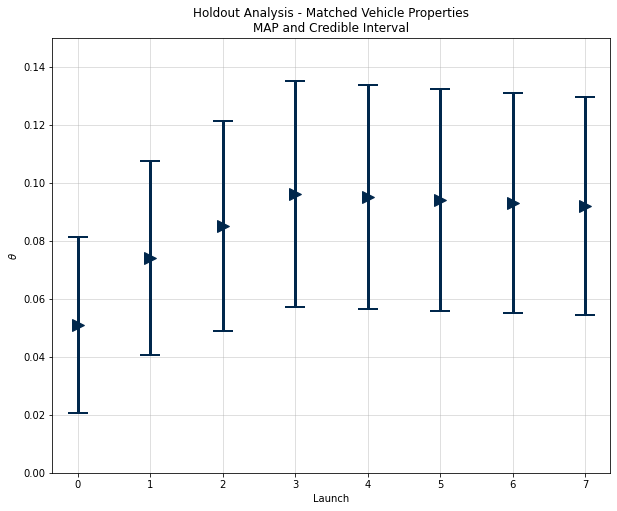

In [145]:
#This is to answer the following: -	Match mass, stage, generation + first 7 in "Matched Vehicle Properties"

def match_mass_gen_stage(launch_results=1,Mass_Cat=1, Veh_Generation=1, Number_of_Stages=2):
    print('masscat:',Mass_Cat,'gen:',Veh_Generation,'stages:', Number_of_Stages)
    
    #Determine the past performance for the Prior
    interim_df = df.loc[(df['Mass_Cat']==Mass_Cat) & (df['Veh_Generation']==Veh_Generation) & (df['Number_of_Stages']==Number_of_Stages)].copy()
    total_successes = max(interim_df['Success_Bool'].cumsum())
    total_failures = max(interim_df['Failure_Bool'].cumsum())
    total_launches = total_successes + total_failures
   
    prior_successes = total_successes
    prior_failures = total_failures
    new_successes = 0
    new_failures = 0
    attempt=0
    save_figs = 1

    print('Total successes: ', total_successes, ', Total failures: ',total_failures)
    
    # Beta Plot
    #To get the Prior
    x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
    plt.plot(x, prior_y, color='lightblue', linestyle='--', label='Matched Prior')
    print("launch:",attempt, "MAP:",round(bayes_map_posterior_x,3),"lower cred:",round(posterior_lower_cred_int,3), "upper cred:",round(posterior_upper_cred_int,3))

    #To plot the posterior(s)
    for launch in launch_results:
        attempt += 1
        if launch:
            new_failures += 1
        else:
            new_successes += 1
        print(attempt,launch, new_successes, new_failures)
        
        x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
        if launch:
            label_text='launch attempt: '+ str(attempt) +' (F)'
        else:
            label_text='launch attempt: '+ str(attempt) +' (S)'
    
        plt.plot(x, posterior_y, label=label_text)

 
    legend = plt.legend(loc='best', shadow=True, fontsize='large')
    title_string= 'Holdout Analysis - Matched Vehicle Properties'
    plt.title(title_string)
    plt.grid()
    fix_axis()
    plt.xlim(0,0.4)
    text_box = 'Launch Performance (1=F):\n' + str(launch_results)
    #plt.text(0.2,10,text_box,bbox=dict(facecolor='lightgray',boxstyle='round,pad=0.25',alpha=0.95), ha="center", va="center")

    if save_figs:
        print('you need to put something here!')
        filename = 'HOA-matched_veh_beta.png'
        plt.savefig(filename, dpi = 300, bbox_inches='tight')
        plt.show()
    else:
        plt.show()
        
        
    # Error Plot Style
    prior_successes = total_successes
    prior_failures = total_failures
    new_successes = 0
    new_failures = 0
    attempt=0

    #To get the Prior
    x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
#     plt.plot(x, prior_y, color='lightblue', linestyle='--', label='Matched Prior')

    #making a little tweak to just grab the cred range for the prior
    x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
    prior_successes = total_successes
    prior_failures = total_failures
    new_successes = total_successes
    new_failures = total_failures
    
    asymmetric_error = np.array(bayes_map_posterior_x-posterior_lower_cred_int, posterior_upper_cred_int-bayes_map_posterior_x)
    plt.errorbar(0, bayes_map_prior_x, yerr=asymmetric_error, fmt='>', capsize=10, color=michigan_blue, elinewidth=3, capthick=2, markersize=12)

    #To plot the posterior(s)
    for launch in launch_results:
        attempt += 1
        if launch:
            new_failures += 1
        else:
            new_successes += 1
       

        x, prior_y, posterior_y, prior_MLE, posterior_, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
        #To Print Stats
        print("launch:",attempt, "MAP:",round(bayes_map_posterior_x,3),"lower cred:",round(posterior_lower_cred_int,3), "upper cred:",round(posterior_upper_cred_int,3))
        
        
        if launch:
            label_text='launch attempt: '+ str(attempt) +' (F)'
        else:
            label_text='launch attempt: '+ str(attempt) +' (S)'
    
        asymmetric_error = np.array(bayes_map_posterior_x-posterior_lower_cred_int, posterior_upper_cred_int-bayes_map_posterior_x)
        plt.errorbar(attempt, bayes_map_posterior_x, yerr=asymmetric_error, fmt='>', capsize=10, color=michigan_blue, elinewidth=3, capthick=2, markersize=12)
        plt.grid(alpha=0.5)
        plt.ylim(0,0.15)
        plt.xlabel('Launch')
        plt.ylabel(r'$\theta$')
        title_string= 'Holdout Analysis - Matched Vehicle Properties\nMAP and Credible Interval'

        plt.title(title_string)
    if save_figs:
        print('you need to put something here!')
        filename = 'HOA-matched_veh_err.png'
        plt.savefig(filename, dpi = 300, bbox_inches='tight')
    else:
        plt.show()

datafile = '../08-Datasets/Aggregated_SLR_Dataset_v4.xlsx'
datatab = 'All-exclusions'

# Import data for evaluation
df = pd.read_excel(datafile, sheet_name=datatab,engine="openpyxl")
df = df.reset_index()    
    
launch_results=[1, 1, 1, 0, 0, 0, 0] #1 is a failure
match_mass_gen_stage(launch_results=launch_results,Mass_Cat=1,Veh_Generation=1,Number_of_Stages=3)

Total successes:  206 , Total failures:  14
Launch Target:  5 Failures:  14 Successes:  206 Total Launches:  220
launch: 0 MAP: 0.06 lower cred: 0.039 upper cred: 0.093


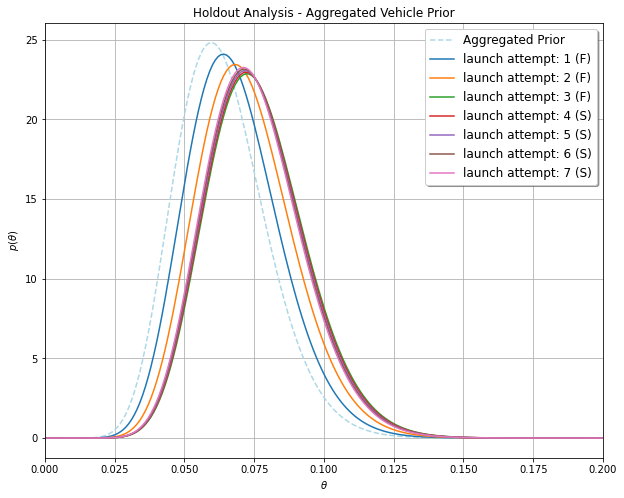

launch: 1 MAP: 0.068 lower cred: 0.046 upper cred: 0.102
launch: 2 MAP: 0.072 lower cred: 0.049 upper cred: 0.107
launch: 3 MAP: 0.076 lower cred: 0.053 upper cred: 0.112
launch: 4 MAP: 0.076 lower cred: 0.052 upper cred: 0.111
launch: 5 MAP: 0.075 lower cred: 0.052 upper cred: 0.111
launch: 6 MAP: 0.075 lower cred: 0.052 upper cred: 0.11
launch: 7 MAP: 0.075 lower cred: 0.052 upper cred: 0.11
you need to put something here!


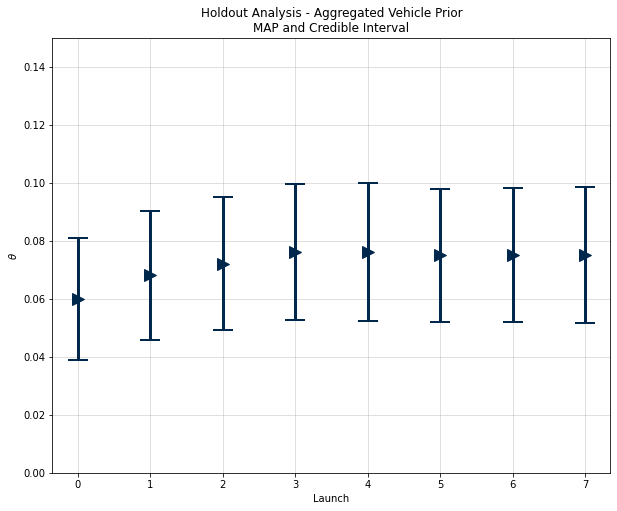

In [146]:
#This is to answer the following: Aggregated Vehicle Prior in "Aggregated Vehicle Prior"
def aggregated_veh_prior(targets=20, launch_results=0):
    verbose = 0
    failures = 0
    successes = 0
    attempt=0
    asymmetric_error = []
    
    save_figs = 1

    
    for target in targets:
        num_failures = 0
        num_successes = 0
        num_launches = 0
        
        rslt_df = pd.DataFrame()
        plot_df = pd.DataFrame()

        vhcl_fam_list = []
        successes_at_target = []
        failures_at_target = []
        launches_at_target = []
        candidate_vhcl_fam_list = []

        Veh_Family=df['Veh_Family'].unique()
        Veh_Family.sort()

        for vhcl_fam in Veh_Family:
            if verbose: print('vhcl=',vhcl_fam)
            rslt_df = df.loc[df['Veh_Family']==vhcl_fam]

            rslt_df.set_index('Date')

            total_successes = max(rslt_df['Success_Bool'].cumsum())
            total_failures = max(rslt_df['Failure_Bool'].cumsum())
            total_launches = total_successes + total_failures

            if total_launches < target:
                if verbose: print(vhcl_fam,'has too few launches')
            else:
                candidate_vhcl_fam_list.append(vhcl_fam)
            
        
        if verbose: print('Candidate List at target of',target,':\n',candidate_vhcl_fam_list)

        
            
        interim_df = pd.DataFrame()
        rslt_df = pd.DataFrame()
        rslt_df = pd.DataFrame(columns=['vhcl_fam','launches_at_target','successes_at_target','failures_at_target'])

        for vhcl_fam in candidate_vhcl_fam_list:
            if verbose: print('vhcl=',vhcl_fam)
            interim_df = pd.DataFrame()
            interim_df = df.loc[df['Veh_Family']==vhcl_fam].copy()
            vhcl_fam_list.append(vhcl_fam)
            interim_df.set_index('Date')
                        
            successes, failures = find_stats(interim_df, target=target)
            if verbose: print(vhcl_fam, successes, failures)
            
            num_failures += failures
            num_successes += successes

            if verbose: print(num_failures, num_successes)
        
        total_failures = num_failures
        total_successes = num_successes
        print('Total successes: ', total_successes, ', Total failures: ',total_failures)

        print("Launch Target: ", target, "Failures: ", num_failures, "Successes: ", num_successes, "Total Launches: ", num_failures+num_successes)

    # To get prior
    prior_successes = total_successes
    prior_failures = total_failures
    new_successes = 0
    new_failures = 0
    attempt = 0
    
    x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
    plt.plot(x, prior_y, color='lightblue', linestyle='--', label='Aggregated Prior')
    print("launch:",attempt, "MAP:",round(bayes_map_posterior_x,3),"lower cred:",round(posterior_lower_cred_int,3), "upper cred:",round(posterior_upper_cred_int,3))

    #To plot the posterior(s)
    for launch in launch_results:
        attempt += 1
        if launch:
            new_failures += 1
        else:
            new_successes += 1
        
        x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
        if launch:
            label_text='launch attempt: '+ str(attempt) +' (F)'
        else:
            label_text='launch attempt: '+ str(attempt) +' (S)'
    
        plt.plot(x, posterior_y, label=label_text)

 
    legend = plt.legend(loc='best', shadow=True, fontsize='large')
    title_string= 'Holdout Analysis - Aggregated Vehicle Prior'
    plt.title(title_string)
    plt.grid()
    fix_axis()
    plt.xlim(0,0.2)
    text_box = 'Launch Performance (1=F):\n' + str(launch_results)
    #plt.text(0.2,10,text_box,bbox=dict(facecolor='lightgray',boxstyle='round,pad=0.25',alpha=0.95), ha="center", va="center")
    if save_figs:
        filename = 'HOA-agg_beta.png'
        plt.savefig(filename, dpi = 300, bbox_inches='tight')
        plt.show()
    else:
        plt.show()
    
    # Error Plot Style
    prior_successes = total_successes
    prior_failures = total_failures
    new_successes = 0
    new_failures = 0
    attempt = 0

    #To get the Prior
#     making a little tweak to just grab the cred range for the prior
    x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
    prior_successes = 1
    prior_failures = 1
    new_successes = 1
    new_failures = 1
    
    asymmetric_error = np.array(bayes_map_posterior_x-posterior_lower_cred_int, posterior_upper_cred_int-bayes_map_posterior_x)
    plt.errorbar(0, bayes_map_prior_x, yerr=asymmetric_error, fmt='>', capsize=10, color=michigan_blue, elinewidth=3, capthick=2, markersize=12)

    prior_successes = total_successes
    prior_failures = total_failures
    #To plot the posterior(s)
    for launch in launch_results:
        attempt += 1
        if launch:
            new_failures += 1
        else:
            new_successes += 1

  
        x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
        # To Print Stats
        print("launch:",attempt, "MAP:",round(bayes_map_posterior_x,3),"lower cred:",round(posterior_lower_cred_int,3), "upper cred:",round(posterior_upper_cred_int,3))
        if launch:
            label_text='launch attempt: '+ str(attempt) +' (F)'
        else:
            label_text='launch attempt: '+ str(attempt) +' (S)'
    
        asymmetric_error = np.array(bayes_map_posterior_x-posterior_lower_cred_int, posterior_upper_cred_int-bayes_map_posterior_x)
        plt.errorbar(attempt, bayes_map_posterior_x, yerr=asymmetric_error, fmt='>', capsize=10, color=michigan_blue, elinewidth=3, capthick=2, markersize=12)
        plt.grid(alpha=0.5)
        plt.ylim(0,0.15)
        plt.xlabel('Launch')
        plt.ylabel(r'$\theta$')
        title_string= 'Holdout Analysis - Aggregated Vehicle Prior\nMAP and Credible Interval'

        plt.title(title_string)
    if save_figs:
        print('you need to put something here!')
        filename = 'HOA-agg_err.png'
        plt.savefig(filename, dpi = 300, bbox_inches='tight')
    else:
        plt.show()
       
            

            
datafile = '../08-Datasets/Aggregated_SLR_Dataset_v4.xlsx'
datatab = 'All-exclusions'

# Import data for evaluation
df = pd.read_excel(datafile, sheet_name=datatab,engine="openpyxl")
df = df.reset_index()

targets=[5]
launch_results=[1, 1, 1, 0, 0, 0, 0] #1 is a failure

aggregated_veh_prior(targets=targets, launch_results=launch_results)




launch: 0 MAP: 0.015 lower cred: 0.05 upper cred: 0.95
1 1 0 1
2 1 0 2
3 1 0 3
4 0 1 3
5 0 2 3
6 0 3 3
7 0 4 3
you need to put something here!


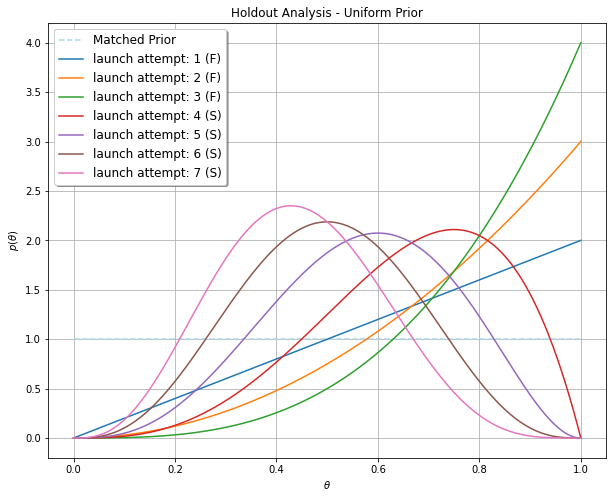

launch: 1 MAP: 1.0 lower cred: 0.224 upper cred: 0.975
launch: 2 MAP: 1.0 lower cred: 0.368 upper cred: 0.983
launch: 3 MAP: 1.0 lower cred: 0.473 upper cred: 0.987
launch: 4 MAP: 0.75 lower cred: 0.343 upper cred: 0.924
launch: 5 MAP: 0.6 lower cred: 0.271 upper cred: 0.847
launch: 6 MAP: 0.499 lower cred: 0.225 upper cred: 0.775
launch: 7 MAP: 0.428 lower cred: 0.193 upper cred: 0.711
you need to put something here!


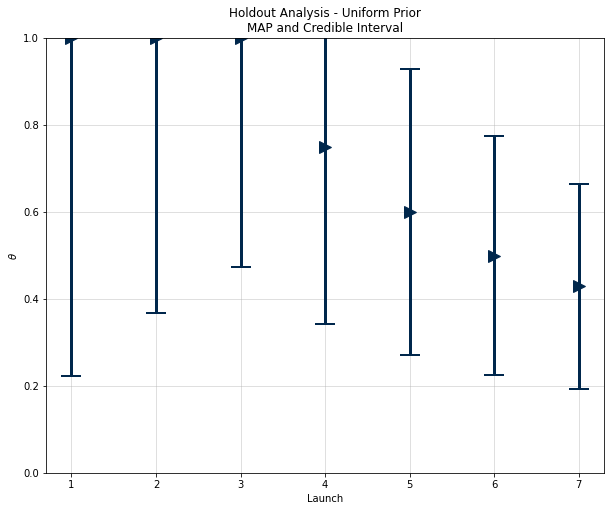

In [147]:
#This is to answer the following: -	Uniform Prior + first 7 in "Uniform Prior"

def uniform_prior(launch_results=1):
    
    #Determine the past performance for the Prior
#     interim_df = df.loc[(df['Mass_Cat']==Mass_Cat) & (df['Veh_Generation']==Veh_Generation) & (df['Number_of_Stages']==Number_of_Stages)].copy()
#     total_successes = max(interim_df['Success_Bool'].cumsum())
#     total_failures = max(interim_df['Failure_Bool'].cumsum())
#     total_launches = total_successes + total_failures
   
    prior_successes = 1
    prior_failures = 1
    new_successes = 0
    new_failures = 0
    attempt=0
    save_figs = 1

    # Beta Plot
    #To get the Prior
    x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
    plt.plot(x, prior_y, color='lightblue', linestyle='--', label='Matched Prior')
    print("launch:",attempt, "MAP:",round(bayes_map_posterior_x,3),"lower cred:",round(posterior_lower_cred_int,3), "upper cred:",round(posterior_upper_cred_int,3))

    #To plot the posterior(s)
    for launch in launch_results:
        attempt += 1
        if launch:
            new_failures += 1
        else:
            new_successes += 1
        print(attempt,launch, new_successes, new_failures)
        
        x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
        if launch:
            label_text='launch attempt: '+ str(attempt) +' (F)'
        else:
            label_text='launch attempt: '+ str(attempt) +' (S)'
    
        plt.plot(x, posterior_y, label=label_text)

 
    legend = plt.legend(loc='best', shadow=True, fontsize='large')
    title_string= 'Holdout Analysis - Uniform Prior'
    plt.title(title_string)
    plt.grid()
    fix_axis()
#     plt.xlim(0,0.4)
    text_box = 'Launch Performance (1=F):\n' + str(launch_results)
    #plt.text(0.2,10,text_box,bbox=dict(facecolor='lightgray',boxstyle='round,pad=0.25',alpha=0.95), ha="center", va="center")

    if save_figs:
        print('you need to put something here!')
        filename = 'HOA-uniform_beta.png'
        plt.savefig(filename, dpi = 300, bbox_inches='tight')
        plt.show()
    else:
        plt.show()
    
    
    
    
    
    
    # Error Plot Style
    
    prior_successes = 1
    prior_failures = 1
    new_successes = 0
    new_failures = 0
    attempt=0

    #To get the Prior
#     x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
#     plt.plot(x, prior_y, color='lightblue', linestyle='--', label='Matched Prior')

    #making a little tweak to just grab the cred range for the prior
#     x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
#     prior_successes = 1
#     prior_failures = 1
#     new_successes = 1
#     new_failures = 1
    
#     asymmetric_error = np.array(bayes_map_posterior_x-posterior_lower_cred_int, posterior_upper_cred_int-bayes_map_posterior_x)
#     plt.errorbar(0, bayes_map_prior_x, yerr=asymmetric_error, fmt='>', capsize=10, color=michigan_blue, elinewidth=3, capthick=2, markersize=12)

    #To plot the posterior(s)
    for launch in launch_results:
        attempt += 1
        if launch:
            new_failures += 1
        else:
            new_successes += 1
        
   
        x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
     # To Print Stats
        print("launch:",attempt, "MAP:",round(bayes_map_posterior_x,3),"lower cred:",round(posterior_lower_cred_int,3), "upper cred:",round(posterior_upper_cred_int,3))
  
        if launch:
            label_text='launch attempt: '+ str(attempt) +' (F)'
        else:
            label_text='launch attempt: '+ str(attempt) +' (S)'
    
        asymmetric_error = np.array(bayes_map_posterior_x-posterior_lower_cred_int, posterior_upper_cred_int-bayes_map_posterior_x)
        plt.errorbar(attempt, bayes_map_posterior_x, yerr=asymmetric_error, fmt='>', capsize=10, color=michigan_blue, elinewidth=3, capthick=2, markersize=12)
        plt.grid(alpha=0.5)
        plt.ylim(0,1)
        plt.xlabel('Launch')
        plt.ylabel(r'$\theta$')
        title_string= 'Holdout Analysis - Uniform Prior\nMAP and Credible Interval'

        plt.title(title_string)
    if save_figs:
        print('you need to put something here!')
        filename = 'HOA-uniform_err.png'
        plt.savefig(filename, dpi = 300, transparent = False, bbox_inches='tight')
    else:
        plt.show()

datafile = '../08-Datasets/Aggregated_SLR_Dataset_v4.xlsx'
datatab = 'All-exclusions'

# Import data for evaluation
df = pd.read_excel(datafile, sheet_name=datatab,engine="openpyxl")
df = df.reset_index()    
    
launch_results=[1, 1, 1, 0, 0, 0, 0] #1 is a failure
uniform_prior(launch_results=launch_results)

launch: 0 MAP: 0.0 lower cred: 0.0 upper cred: 0.292
1 1 0 1
2 1 0 2
3 1 0 3
4 0 1 3
5 0 2 3
6 0 3 3
7 0 4 3
you need to put something here!


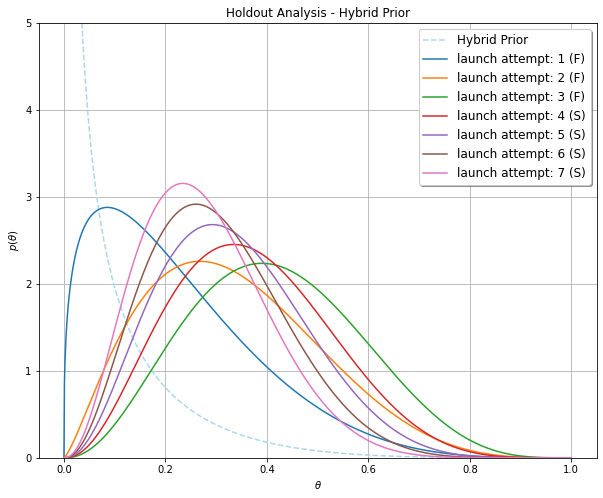

launch: 1 MAP: 0.085 lower cred: 0.027 upper cred: 0.53
launch: 2 MAP: 0.268 lower cred: 0.09 upper cred: 0.636
launch: 3 MAP: 0.39 lower cred: 0.16 upper cred: 0.701
launch: 4 MAP: 0.334 lower cred: 0.137 upper cred: 0.639
launch: 5 MAP: 0.292 lower cred: 0.121 upper cred: 0.587
launch: 6 MAP: 0.26 lower cred: 0.108 upper cred: 0.542
launch: 7 MAP: 0.234 lower cred: 0.097 upper cred: 0.503
you need to put something here!


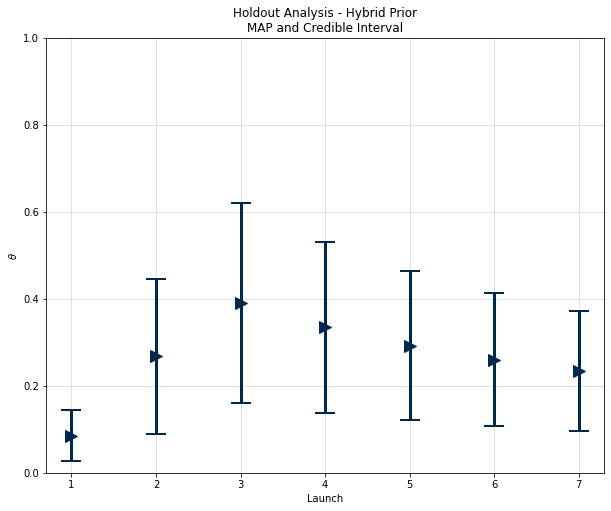

In [148]:
#This is to answer the following: -	Hybrid Prior

def hybrid_prior(launch_results=1):
    
    #Determine the past performance for the Prior
#     interim_df = df.loc[(df['Mass_Cat']==Mass_Cat) & (df['Veh_Generation']==Veh_Generation) & (df['Number_of_Stages']==Number_of_Stages)].copy()
#     total_successes = max(interim_df['Success_Bool'].cumsum())
#     total_failures = max(interim_df['Failure_Bool'].cumsum())
#     total_launches = total_successes + total_failures
   
    factor = 5
    prior_successes = 0.9316 * factor
    prior_failures = 0.0684 * factor
    
    
    new_successes = 0
    new_failures = 0
    attempt=0
    save_figs = 1

    # Beta Plot
    #To get the Prior
    x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
    plt.plot(x, prior_y, color='lightblue', linestyle='--', label='Hybrid Prior')
    print("launch:",attempt, "MAP:",round(bayes_map_posterior_x,3),"lower cred:",round(posterior_lower_cred_int,3), "upper cred:",round(posterior_upper_cred_int,3))

    #To plot the posterior(s)
    for launch in launch_results:
        attempt += 1
        if launch:
            new_failures += 1
        else:
            new_successes += 1
        print(attempt,launch, new_successes, new_failures)
        
        x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
        if launch:
            label_text='launch attempt: '+ str(attempt) +' (F)'
        else:
            label_text='launch attempt: '+ str(attempt) +' (S)'
    
        plt.plot(x, posterior_y, label=label_text)

 
    legend = plt.legend(loc='best', shadow=True, fontsize='large')
    title_string= 'Holdout Analysis - Hybrid Prior'
    plt.title(title_string)
    plt.grid()
    fix_axis()
#     plt.xlim(0,0.4)
    plt.ylim(0,5)
    text_box = 'Launch Performance (1=F):\n' + str(launch_results)
    #plt.text(0.2,10,text_box,bbox=dict(facecolor='lightgray',boxstyle='round,pad=0.25',alpha=0.95), ha="center", va="center")

    if save_figs:
        print('you need to put something here!')
        filename = 'HOA-hybrid_beta.png'
        plt.savefig(filename, dpi = 300, bbox_inches='tight')
        plt.show()
    else:
        plt.show()
    
    
    
    
    
    
    # Error Plot Style
    
    new_successes = 0
    new_failures = 0
    attempt=0

    #To get the Prior
#     x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
#     plt.plot(x, prior_y, color='lightblue', linestyle='--', label='Matched Prior')

    #making a little tweak to just grab the cred range for the prior
#     x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
#     prior_successes = 1
#     prior_failures = 1
#     new_successes = 1
#     new_failures = 1
    
#     asymmetric_error = np.array(bayes_map_posterior_x-posterior_lower_cred_int, posterior_upper_cred_int-bayes_map_posterior_x)
#     plt.errorbar(0, bayes_map_prior_x, yerr=asymmetric_error, fmt='>', capsize=10, color=michigan_blue, elinewidth=3, capthick=2, markersize=12)

    #To plot the posterior(s)
    for launch in launch_results:
        attempt += 1
        if launch:
            new_failures += 1
        else:
            new_successes += 1
        
  
        x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
      # To Print Stats
        print("launch:",attempt, "MAP:",round(bayes_map_posterior_x,3),"lower cred:",round(posterior_lower_cred_int,3), "upper cred:",round(posterior_upper_cred_int,3))
   
        if launch:
            label_text='launch attempt: '+ str(attempt) +' (F)'
        else:
            label_text='launch attempt: '+ str(attempt) +' (S)'
    
        asymmetric_error = np.array(bayes_map_posterior_x-posterior_lower_cred_int, posterior_upper_cred_int-bayes_map_posterior_x)
        plt.errorbar(attempt, bayes_map_posterior_x, yerr=asymmetric_error, fmt='>', capsize=10, color=michigan_blue, elinewidth=3, capthick=2, markersize=12)
        plt.grid(alpha=0.5)
        plt.ylim(0,1)
        plt.xlabel('Launch')
        plt.ylabel(r'$\theta$')
        title_string= 'Holdout Analysis - Hybrid Prior\nMAP and Credible Interval'

        plt.title(title_string)
    if save_figs:
        print('you need to put something here!')
        filename = 'HOA-hybrid_err.png'
        plt.savefig(filename, dpi = 300, transparent = False, bbox_inches='tight')
    else:
        plt.show()

datafile = '../08-Datasets/Aggregated_SLR_Dataset_v4.xlsx'
datatab = 'All-exclusions'

# Import data for evaluation
df = pd.read_excel(datafile, sheet_name=datatab,engine="openpyxl")
df = df.reset_index()    
    
launch_results=[1, 1, 1, 0, 0, 0, 0] #1 is a failure
hybrid_prior(launch_results=launch_results)

In [149]:
def first_launches(df, launch_number=20):
    fun_df = pd.DataFrame()
    fun_df = df.copy()
    fun_df['pandas_running_successes'] = fun_df['Success_Bool'].cumsum()
    fun_df['pandas_running_failures'] = fun_df['Failure_Bool'].cumsum()
    fun_df['pandas_running_launches'] = fun_df['pandas_running_failures']+fun_df['pandas_running_successes']
    successes = fun_df['pandas_running_successes'].loc[fun_df['pandas_running_launches'] == launch_number].item()
    failures = fun_df['pandas_running_failures'].loc[fun_df['pandas_running_launches'] == launch_number].item()
#     print(rslt_df['pandas_running_launches'])
    #print(rslt_df['pandas_running_launches'].loc[rslt_df['pandas_running_launches'] <= launch_number])
    filtered_df = fun_df.loc[fun_df['pandas_running_launches'] == launch_number]
#     print(filtered_df)
    return filtered_df

Launch Target:  1 Failures:  24 Successes:  68 Total Launches:  92
Launch Target:  2 Failures:  24 Successes:  116 Total Launches:  140
Launch Target:  3 Failures:  21 Successes:  156 Total Launches:  177
Launch Target:  4 Failures:  13 Successes:  183 Total Launches:  196
Launch Target:  5 Failures:  14 Successes:  206 Total Launches:  220


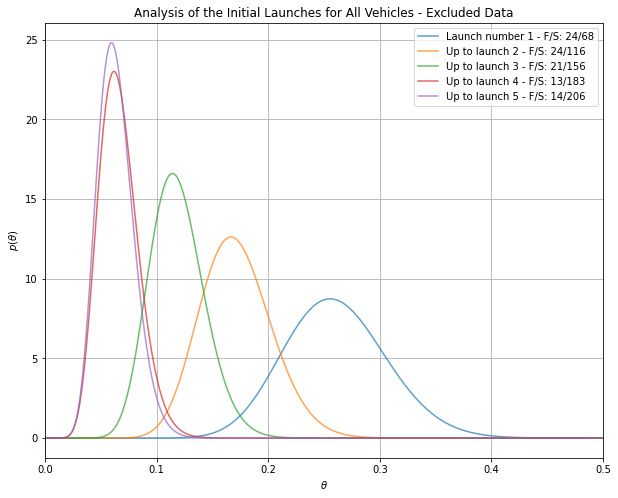

In [150]:
def exclusion_analysis_all_vehicles_aggregate_launches(targets=20, linestyle='-',write_csv=False, plot_it=False):
    verbose = 0
    failures = 0
    successes = 0
    
    for target in targets:
        num_failures = 0
        num_successes = 0
        num_launches = 0
        
        rslt_df = pd.DataFrame()
        plot_df = pd.DataFrame()

        vhcl_fam_list = []
        successes_at_target = []
        failures_at_target = []
        launches_at_target = []
        candidate_vhcl_fam_list = []

        Veh_Family=df['Veh_Family'].unique()
        Veh_Family.sort()

        for vhcl_fam in Veh_Family:
            if verbose: print('vhcl=',vhcl_fam)
            rslt_df = df.loc[df['Veh_Family']==vhcl_fam]

            rslt_df.set_index('Date')

            total_successes = max(rslt_df['Success_Bool'].cumsum())
            total_failures = max(rslt_df['Failure_Bool'].cumsum())
            total_launches = total_successes + total_failures

            if total_launches < target:
                if verbose: print(vhcl_fam,'has too few launches')
            else:
                candidate_vhcl_fam_list.append(vhcl_fam)
            
        
        if verbose: print('Candidate List at target of',target,':\n',candidate_vhcl_fam_list)

        interim_df = pd.DataFrame()
        rslt_df = pd.DataFrame()
        rslt_df = pd.DataFrame(columns=['vhcl_fam','launches_at_target','successes_at_target','failures_at_target'])

        for vhcl_fam in candidate_vhcl_fam_list:
            if verbose: print('vhcl=',vhcl_fam)
            interim_df = pd.DataFrame()
            interim_df = df.loc[df['Veh_Family']==vhcl_fam].copy()
            vhcl_fam_list.append(vhcl_fam)
            interim_df.set_index('Date')
                        
            successes, failures = find_stats(interim_df, target=target)
            if verbose: print(vhcl_fam, successes, failures)
            
            num_failures += failures
            num_successes += successes

            if verbose: print(num_failures, num_successes)
        
        print("Launch Target: ", target, "Failures: ", num_failures, "Successes: ", num_successes, "Total Launches: ", num_failures+num_successes)
        
        if plot_it:
            prior_successes = 0
            prior_failures = 0
            new_successes = num_successes
            new_failures = num_failures
            x, prior_y, posterior_y, prior_MLE, posterior_MLE, bayes_map_prior_x, bayes_map_posterior_x, prior_lower_cred_int, prior_upper_cred_int, posterior_lower_cred_int, posterior_upper_cred_int = calc_prior(prior_successes, prior_failures, new_successes, new_failures)
            if target == 1:
                plot_label= 'Launch number '+ str(target) +' - F/S: ' + str(num_failures) + '/' + str(num_successes)
            else:
                plot_label= 'Up to launch '+ str(target) +' - F/S: ' + str(num_failures) + '/' + str(num_successes)

            
            if len(targets) == 1: plt.axvline(bayes_map_posterior_x, color='orange', alpha=0.5, linestyle='--')
            if len(linestyle) < 2: plt.plot(x, posterior_y, alpha=0.7,label=plot_label)
            if len(linestyle) >= 2: plt.plot(x, posterior_y, alpha=0.7,label=plot_label, linestyle=linestyle[target-1])

datafile = '../08-Datasets/Aggregated_SLR_Dataset_v4.xlsx'
datatab = 'All-exclusions'

# Import data for evaluation
df = pd.read_excel(datafile, sheet_name=datatab,engine="openpyxl")
df = df.reset_index()

targets=[1, 2, 3, 4, 5]
linestyle=['-','--',':','-.','-']
exclusion_analysis_all_vehicles_aggregate_launches(targets=targets, write_csv=False, plot_it=True)


plt.title('Analysis of the Initial Launches for All Vehicles - Excluded Data')
plt.grid()
plt.legend()
plt.xlim(0,0.5)
fix_axis()
plt.savefig('first_launches_excluded_data.png', dpi = 300, bbox_inches='tight')

plt.show()